In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import json

import torch
import torch.nn as nn
import multiprocessing as mp

# Machine Learning and Data Science Imports (basics)
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, Input, optimizers
from tensorflow.keras.utils import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
import random

import plotly.io as pio
print(pio.renderers)

Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import math
import gc
import sys
import scipy

In [3]:
!pip install -q --upgrade tensorflow-io

^C
ERROR: Operation cancelled by user


In [4]:
def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

In [5]:
LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"
json_file_path = "/kaggle/input/asl-signs/sign_to_prediction_index_map.json"
label_map = json.load(open(json_file_path, "r"))

### FCNN Model
#### The dataset:

The load_relevant_data_subset function used by the hosts only yields x, y, z values, which we need to consider when building our models.

The dataset consists of tfrecords created in a separate notebook, with examples structured as follows:
- 3 key frames for each type (usually the first and then 2 most disparate non-zero frames)
- Only X, Y coordinates are included
- Each type is stored separately: 'face': 468, 'left_hand': 21, 'pose': 33, 'right_hand': 21
- The label is stored as an integer (sparse)
- Note: This is a work-in-progress and some issues are being resolved. For now, a simple model will be created using the basic mean numpy data that others are using.

#### The Model:

- Only hands will be used initially, discarding pose and face information.
- Two batch dimensions will be used:
- The real batch dimension
- The frame batch dimension
- This approach will allow for processing/learning of more data and can be batched similarly during inference.

In [6]:
class FeatureGen(nn.Module):
    def __init__(self):
        super(FeatureGen, self).__init__()
        pass
    
    def forward(self, x):
        face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lefth_x = x[:,468:489,:].contiguous().view(-1, 21*3)
        pose_x = x[:,489:522,:].contiguous().view(-1, 33*3)
        righth_x = x[:,522:,:].contiguous().view(-1, 21*3)
        
        lefth_x = lefth_x[~torch.any(torch.isnan(lefth_x), dim=1),:]
        righth_x = righth_x[~torch.any(torch.isnan(righth_x), dim=1),:]
        
        x1m = torch.mean(face_x, 0)
        x2m = torch.mean(lefth_x, 0)
        x3m = torch.mean(pose_x, 0)
        x4m = torch.mean(righth_x, 0)
        
        x1s = torch.std(face_x, 0)
        x2s = torch.std(lefth_x, 0)
        x3s = torch.std(pose_x, 0)
        x4s = torch.std(righth_x, 0)
        
        xfeat = torch.cat([x1m,x2m,x3m,x4m, x1s,x2s,x3s,x4s], axis=0)
        xfeat = torch.where(torch.isnan(xfeat), torch.tensor(0.0, dtype=torch.float32), xfeat)
        
        return xfeat
    
feature_converter = FeatureGen()

In [7]:
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
# Define a function to convert a row of data
def convert_row(row):
    # Load relevant data subset using the row's path
    x = load_relevant_data_subset(os.path.join("/kaggle/input/asl-signs", row[1].path))
    # Convert the data using a feature converter and convert to numpy array
    x = feature_converter(torch.tensor(x)).cpu().numpy()
    # Return the converted data and its label
    return x, row[1].label

# Define a function to convert and save data
def convert_and_save_data():
    # Read CSV file into a DataFrame
    df = pd.read_csv(TRAIN_FILE)
    # Map sign labels to corresponding labels
    df['label'] = df['sign'].map(label_map)
    # Initialize arrays for storing converted data and labels
    npdata = np.zeros((df.shape[0], 3258))
    nplabels = np.zeros(df.shape[0])
    # Use multiprocessing to concurrently convert data
    with mp.Pool() as pool:
        # Use imap to iterate over DataFrame rows and apply convert_row function
        results = pool.imap(convert_row, df.iterrows(), chunksize=250)
        # Loop through the results and store converted data and labels
        for i, (x,y) in tqdm(enumerate(results), total=df.shape[0]):
            npdata[i,:] = x
            nplabels[i] = y
    # Save converted data and labels to numpy arrays
    np.save("feature_data.npy", npdata)
    np.save("feature_labels.npy", nplabels)

# Call the convert_and_save_data function to start the data conversion and saving process
convert_and_save_data()

In [28]:
# Load feature data and labels
train_x = np.load("/kaggle/working/feature_data.npy").astype(np.float32)
train_y = np.load("/kaggle/working/feature_labels.npy").astype(np.uint8)

# Set batch size
BATCH_SIZE = 64

# Calculate total number of samples
N_TOTAL = train_x.shape[0]

# Set validation percentage
VAL_PCT = 0.1

# Set test percentage
TEST_PCT = 0.1

# Calculate number of validation and training samples
N_VAL = int(N_TOTAL * VAL_PCT)
N_TEST = int(N_TOTAL * TEST_PCT)
N_TRAIN = N_TOTAL - N_VAL - N_TEST

# Randomly sample indices for training, validation, and test data
random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs = np.array(random_idxs[:N_TRAIN])
val_idxs = np.array(random_idxs[N_TRAIN:N_TRAIN+N_VAL])
test_idxs = np.array(random_idxs[N_TRAIN+N_VAL:])

# Split data into validation, training, and test sets
val_x, val_y = train_x[val_idxs], train_y[val_idxs]
test_x, test_y = train_x[test_idxs], train_y[test_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3258)]            0         
                                                                 
 dense_3 (Dense)             (None, 512)               1668608   
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                           

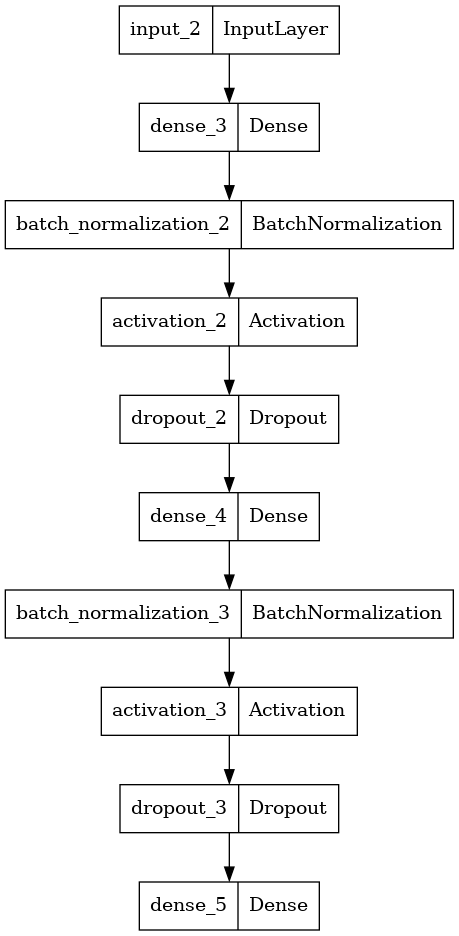

In [30]:
# Define fully connected block
def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

# Define the main model
def get_model(n_labels=250, init_fc=512, n_blocks=2, dropout_1=0.2, dropout_2=0.6, flat_frame_len=3258):
    inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = inputs
    
    # Add fully connected blocks
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=dropout_1 if (1+i)!=n_blocks else dropout_2
        )
    
    # Define output layer
    outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = get_model()
model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", metrics="acc")
model.summary()

# Plot the model architecture
tf.keras.utils.plot_model(model)

In [31]:
!mkdir models
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
]
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, callbacks=cb_list, batch_size=BATCH_SIZE)
model.save("./models/asl_model")

Epoch 1/100
1181/1181 [==============================] - 15s 7ms/step - loss: 5.4307 - acc: 0.0124 - val_loss: 5.2494 - val_acc: 0.0186 - lr: 3.3300e-04
Epoch 2/100
1181/1181 [==============================] - 8s 7ms/step - loss: 4.7112 - acc: 0.0487 - val_loss: 5.0800 - val_acc: 0.0212 - lr: 3.3300e-04
Epoch 3/100
1181/1181 [==============================] - 8s 7ms/step - loss: 4.1249 - acc: 0.1070 - val_loss: 4.6983 - val_acc: 0.0535 - lr: 3.3300e-04
Epoch 4/100
1181/1181 [==============================] - 8s 7ms/step - loss: 3.7480 - acc: 0.1565 - val_loss: 4.7683 - val_acc: 0.0453 - lr: 3.3300e-04
Epoch 5/100
1181/1181 [==============================] - 8s 6ms/step - loss: 3.5174 - acc: 0.1936 - val_loss: 4.5824 - val_acc: 0.0596 - lr: 3.3300e-04
Epoch 6/100
1181/1181 [==============================] - 8s 7ms/step - loss: 3.3563 - acc: 0.2229 - val_loss: 4.7770 - val_acc: 0.0540 - lr: 3.3300e-04
Epoch 7/100
1181/1181 [==============================] - 8s 7ms/step - loss: 3.2131 - a

In [32]:
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
        
DATA_DIR = "/kaggle/input/asl-signs"
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

In [33]:
model.evaluate(test_x, test_y)
for x,y in zip(test_x[:10], test_y[:10]):
    print(f"PRED: {decoder(np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0), axis=-1)[0]):<20} – GT: {decoder(y)}")

296/296 [==============================] - 1s 3ms/step - loss: 1.8283 - acc: 0.5517
PRED: thankyou             – GT: thankyou
PRED: snow                 – GT: beside
PRED: hungry               – GT: hungry
PRED: now                  – GT: now
PRED: wait                 – GT: wait
PRED: thirsty              – GT: fast
PRED: cut                  – GT: weus
PRED: doll                 – GT: doll
PRED: cheek                – GT: ear
PRED: sad                  – GT: wait


In [49]:
y_predicted = model.predict(test_x)

296/296 [==============================] - 1s 2ms/step


In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predictions = y_predicted
labels = test_y

# Convert one-hot encoded predictions to integer labels
pred_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, F1-score, and accuracy for each class
precision = precision_score(labels, pred_labels, average=None)
recall = recall_score(labels, pred_labels, average=None)
f1 = f1_score(labels, pred_labels, average=None)
accuracy = accuracy_score(labels, pred_labels)

# Calculate macro-averaged metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-averaged Precision: {:.2f}%".format(macro_precision * 100))
print("Macro-averaged Recall: {:.2f}%".format(macro_recall * 100))
print("Macro-averaged F1-score: {:.2f}%".format(macro_f1 * 100))

Accuracy: 55.17%
Macro-averaged Precision: 57.16%
Macro-averaged Recall: 55.14%
Macro-averaged F1-score: 53.84%


## Seq to Seq Models - LSTM, GRU, RNN

In [9]:
df_train = pd.read_csv(TRAIN_FILE)
print(df_train.shape)
df_train.head(10)

(94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time


In [10]:
sign_dict = label_map
ordered_signs = list(label_map.keys())
print(ordered_signs)

['TV', 'after', 'airplane', 'all', 'alligator', 'animal', 'another', 'any', 'apple', 'arm', 'aunt', 'awake', 'backyard', 'bad', 'balloon', 'bath', 'because', 'bed', 'bedroom', 'bee', 'before', 'beside', 'better', 'bird', 'black', 'blow', 'blue', 'boat', 'book', 'boy', 'brother', 'brown', 'bug', 'bye', 'callonphone', 'can', 'car', 'carrot', 'cat', 'cereal', 'chair', 'cheek', 'child', 'chin', 'chocolate', 'clean', 'close', 'closet', 'cloud', 'clown', 'cow', 'cowboy', 'cry', 'cut', 'cute', 'dad', 'dance', 'dirty', 'dog', 'doll', 'donkey', 'down', 'drawer', 'drink', 'drop', 'dry', 'dryer', 'duck', 'ear', 'elephant', 'empty', 'every', 'eye', 'face', 'fall', 'farm', 'fast', 'feet', 'find', 'fine', 'finger', 'finish', 'fireman', 'first', 'fish', 'flag', 'flower', 'food', 'for', 'frenchfries', 'frog', 'garbage', 'gift', 'giraffe', 'girl', 'give', 'glasswindow', 'go', 'goose', 'grandma', 'grandpa', 'grass', 'green', 'gum', 'hair', 'happy', 'hat', 'hate', 'have', 'haveto', 'head', 'hear', 'helic

In [11]:
# Number of landmarks per frame
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    # Load data from a parquet file, selecting relevant columns and filling missing values with 0
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns).fillna(0)
    
    # Reshape data into frames with ROWS_PER_FRAME landmarks per frame
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    
    # Convert data to float32
    return data.astype(np.float32)

def load_relevant_data(pq_path):
    # Load data from a parquet file, filling missing values with 0
    data = pd.read_parquet(pq_path).fillna(0)
    
    return data

In [12]:
idx_plot = 3
path_show = "/kaggle/input/asl-signs/"+df_train['path'].values[idx_plot]
sign_plot = df_train['sign'].values[idx_plot]
path_example = path_show.replace("_", "_")

df = load_relevant_data(path_show)
df.head(10)

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
5,17,17-face-5,face,5,0.491820,0.424721,-0.067133
6,17,17-face-6,face,6,0.491240,0.394258,-0.032263
7,17,17-face-7,face,7,0.398341,0.395734,0.017706
8,17,17-face-8,face,8,0.490602,0.367059,-0.023201
9,17,17-face-9,face,9,0.490210,0.353400,-0.025720


In [13]:
# Set the path and sign for visualization
path_show = "/kaggle/input/asl-signs/" + df_train['path'].values[1]
sign_show = df_train['sign'].values[1]

# Load relevant data subset from the specified path
df_example = load_relevant_data_subset(path_show)

# Get the dimensions of the loaded data
frames = df_example.shape[0]
keypoints = df_example.shape[1]
position = df_example.shape[2]

# Print information about the loaded data
print("\nNumber of frames:", frames)
print("Keypoints:", keypoints)
print("X, Y, Z positions:", position)
print("Total number of datapoints in this sequence:", np.prod(df_example.shape))

# Define the number of landmarks for different body parts
pose_landmarks = 33
face_landmarks = 468
right_hand_landmarks = 21
start_left_hand = face_landmarks
left_hand_landmarks = 21
start_right_hand = face_landmarks + left_hand_landmarks + pose_landmarks
total_landmarks = pose_landmarks + face_landmarks + right_hand_landmarks + left_hand_landmarks

# Print information about the landmarks
print("\nPose landmarks:", pose_landmarks)
print("Face landmarks:", face_landmarks)
print("Right hand landmarks:", right_hand_landmarks)
print("Left hand landmarks:", left_hand_landmarks)
print("Total landmarks/keypoints:", total_landmarks)


Number of frames: 11
Keypoints: 543
X, Y, Z positions: 3
Total number of datapoints in this sequence: 17919

Pose landmarks: 33
Face landmarks: 468
Right hand landmarks: 21
Left hand landmarks: 21
Total landmarks/keypoints: 543


In [14]:
from tqdm import tqdm

max_sequence_length = 32
lip_marks = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]

lips = lip_marks
left_hand = [*range(start_left_hand, start_left_hand+left_hand_landmarks, 1)]
right_hand = [*range(start_right_hand, start_right_hand+right_hand_landmarks, 1)]
meaningful_keypoints = lips + left_hand + right_hand
input_length = len(meaningful_keypoints)*3

def get_data(file_paths, y_sign):
    """
    Get data for training or testing.

    Args:
        file_paths (numpy array): Array of file paths for data files.
        y_sign (list): List of target labels for corresponding data files.

    Returns:
        X (numpy array): Array of input data.
        y (numpy array): Array of target labels.

    """

    X = np.empty((file_paths.shape[0], max_sequence_length, len(meaningful_keypoints)*3), dtype=float)

    for i in tqdm(range(file_paths.shape[0])):
        file_name = "/kaggle/input/asl-signs/"+file_paths[i]
        data = load_relevant_data_subset(file_name)
        
        data = data[:, meaningful_keypoints]
        
        if data.shape[0] < max_sequence_length:
            rows = max_sequence_length - data.shape[0]
            data = np.append(np.zeros((rows, len(meaningful_keypoints), 3)), data, axis=0)
        elif data.shape[0] > max_sequence_length:
            data = data[-(max_sequence_length):]

        X[i] = data.reshape(max_sequence_length, len(meaningful_keypoints)*3, order='F')
        
        del data
        
    X = np.asarray(X).astype(np.float32)
        
    y = []
    for sign in y_sign:
        y.append(sign_dict[sign])

    y = np.array(y, dtype=int)

    return X, y

## Training the classifier
## LSTM
## Lets start with a simple LSTM system

In [15]:
def scaled_dot_product(q,k,v, softmax):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [16]:
# a single dense block followed by a normalization block and relu activation
def dense_block(units):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    drop = layers.Dropout(0.05)
    return lambda x: drop(act(norm(fc(x))))

# transformer blocks
def transformer_block(key_dim, x):
    mha = MultiHeadAttention(key_dim, 8)(x)
    add1 = layers.add([mha, x])
    norm1 = layers.LayerNormalization()(add1)

    fc = layers.Dense(key_dim, activation="relu")(norm1)
    add2 = tf.math.add(fc, norm1)
    norm2 = layers.LayerNormalization()(add2)

    return norm2

def classifier_rnn(units):
    rnn = layers.SimpleRNN(units)
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(rnn(x))

# the final dense block for the classification
def classifier_lstm(units):
    lstm = layers.LSTM(units)
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(lstm(x))

# the final dense block for the classification
def classifier_gru(units):
    gru = layers.GRU(units)
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(gru(x))

def classifier_transformer():
    dense = layers.Dense(256, activation="relu")
    drop = layers.Dropout(0.1)
    
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(drop(dense(x)))

inputs = tf.keras.Input(shape=(None, input_length), ragged=True)
# choose the number of nodes per layer
embedding_units = [256, 128, 256] # tune this
transformer_units = []#, 512, 512]

# # dense encoder model
x = inputs
for n in embedding_units:
    x = dense_block(n)(x)
    
for t in transformer_units:
    x = transformer_block(t, x)

# classifier layer
if len(transformer_units) > 0:
    # Pooling
    x = tf.math.reduce_sum(x, axis=1)
    out = classifier_transformer()(x)
else:
    out = classifier_lstm(embedding_units[-1])(x)


model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 246)]       0         
                                                                 
 dense (Dense)               (None, None, 256)         63232     
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 256)         0         
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         32896     
                                                             

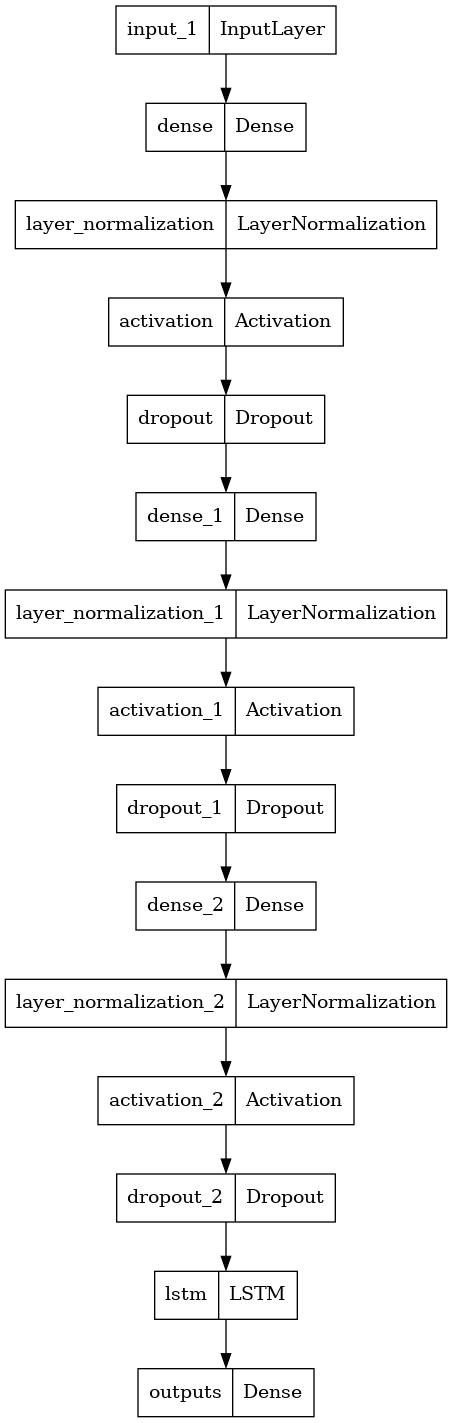

In [17]:
# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png')

In [18]:
# add a decreasing learning rate scheduler to help convergence
batch_size = 256
validation_percentage = 0.05
steps_per_epoch = int(94477*(1-validation_percentage)) // batch_size
boundaries = [steps_per_epoch * n for n in [23, 35, 45, 53, 60]]
print(boundaries)
values = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr_sched)
# optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

[8050, 12250, 15750, 18550, 21000]


In [19]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.2,
            patience = 5
        ),
    ]

In [21]:
file_paths = df_train['path'].values#[:1000]
y_sign = df_train['sign'].values#[:1000]
X, y = get_data(file_paths, y_sign)

X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percentage, random_state=123)
X, X_test, y, y_test = train_test_split(X, y, test_size=validation_percentage, random_state=123)

print(X.shape)
print(y.shape)

history = model.fit(X, y, 
                epochs=500,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=2,
                callbacks=[get_callbacks()]
               )

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

100%|██████████| 94477/94477 [35:07<00:00, 44.84it/s]


(85265, 32, 246)
(85265,)
Epoch 1/500
334/334 - 25s - loss: 4.8825 - accuracy: 0.0428 - sparse_top_k_categorical_accuracy: 0.1444 - val_loss: 4.0016 - val_accuracy: 0.1355 - val_sparse_top_k_categorical_accuracy: 0.3656 - lr: 0.0010 - 25s/epoch - 74ms/step
Epoch 2/500
334/334 - 7s - loss: 3.6513 - accuracy: 0.1833 - sparse_top_k_categorical_accuracy: 0.4446 - val_loss: 3.5357 - val_accuracy: 0.2060 - val_sparse_top_k_categorical_accuracy: 0.4708 - lr: 0.0010 - 7s/epoch - 22ms/step
Epoch 3/500
334/334 - 8s - loss: 3.0681 - accuracy: 0.2887 - sparse_top_k_categorical_accuracy: 0.5827 - val_loss: 2.8691 - val_accuracy: 0.3317 - val_sparse_top_k_categorical_accuracy: 0.6262 - lr: 0.0010 - 8s/epoch - 24ms/step
Epoch 4/500
334/334 - 7s - loss: 2.6877 - accuracy: 0.3661 - sparse_top_k_categorical_accuracy: 0.6589 - val_loss: 2.7357 - val_accuracy: 0.3639 - val_sparse_top_k_categorical_accuracy: 0.6490 - lr: 0.0010 - 7s/epoch - 22ms/step
Epoch 5/500
334/334 - 8s - loss: 2.4450 - accuracy: 0.41

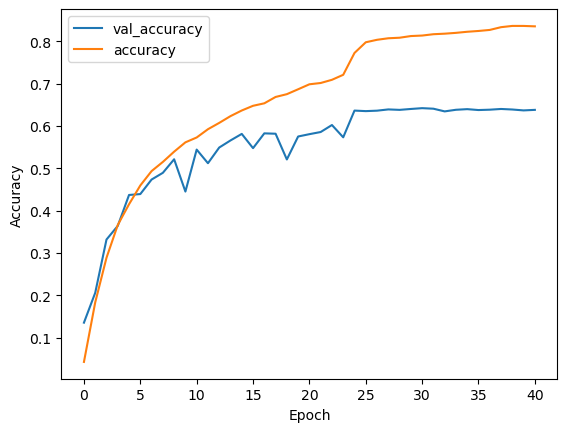

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(val_accuracy, label='val_accuracy')

plt.plot(accuracy, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

In [23]:
# Convert final model in a tf.lite model
# Add a preprocessing pipeline and safe the model as tf.lite model

lips = lip_marks
left_hand = [*range(start_left_hand, start_left_hand+left_hand_landmarks, 1)]
right_hand = [*range(start_right_hand, start_right_hand+right_hand_landmarks, 1)]
meaningful_keypoints = lips + left_hand + right_hand


def get_inference_model(model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs")
    
    # drop most of the face mesh
    x = tf.gather(inputs, meaningful_keypoints, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates ()
    x = tf.concat([x[...,i] for i in range(3)], -1)

    x = tf.expand_dims(x,0)
    
    # call trained model
    out = model(x)
    
    # explicitly name the final (identity) layer for the submission format
    outputs = layers.Activation("linear", name="outputs")(out)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

In [24]:
inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 82, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]

In [25]:
model.evaluate(X_test, y_test)

141/141 [==============================] - 1s 7ms/step - loss: 1.6308 - accuracy: 0.6234 - sparse_top_k_categorical_accuracy: 0.8266


[1.630759835243225, 0.6234402656555176, 0.8266488313674927]

In [27]:
y_test_pred = model.predict(X_test)

141/141 [==============================] - 1s 5ms/step


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predictions = y_test_pred
labels = y_test

# Convert one-hot encoded predictions to integer labels
pred_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, F1-score, and accuracy for each class
precision = precision_score(labels, pred_labels, average=None)
recall = recall_score(labels, pred_labels, average=None)
f1 = f1_score(labels, pred_labels, average=None)
accuracy = accuracy_score(labels, pred_labels)

# Calculate macro-averaged metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-averaged Precision: {:.2f}%".format(macro_precision * 100))
print("Macro-averaged Recall: {:.2f}%".format(macro_recall * 100))
print("Macro-averaged F1-score: {:.2f}%".format(macro_f1 * 100))

Accuracy: 62.34%
Macro-averaged Precision: 62.59%
Macro-averaged Recall: 62.72%
Macro-averaged F1-score: 61.82%


## GRU

In [17]:
inputs = tf.keras.Input(shape=(None, input_length), ragged=True)
# choose the number of nodes per layer
embedding_units = [256, 128, 256] # tune this
transformer_units = []#, 512, 512]

# # dense encoder model
x = inputs
for n in embedding_units:
    x = dense_block(n)(x)
    
for t in transformer_units:
    x = transformer_block(t, x)

# classifier layer
if len(transformer_units) > 0:
    # Pooling
    x = tf.math.reduce_sum(x, axis=1)
    out = classifier_transformer()(x)
else:
    out = classifier_gru(embedding_units[-1])(x)


model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 246)]       0         
                                                                 
 dense_3 (Dense)             (None, None, 256)         63232     
                                                                 
 layer_normalization_3 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, None, 256)         0         
                                                                 
 dropout_3 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_4 (Dense)             (None, None, 128)         32896     
                                                           

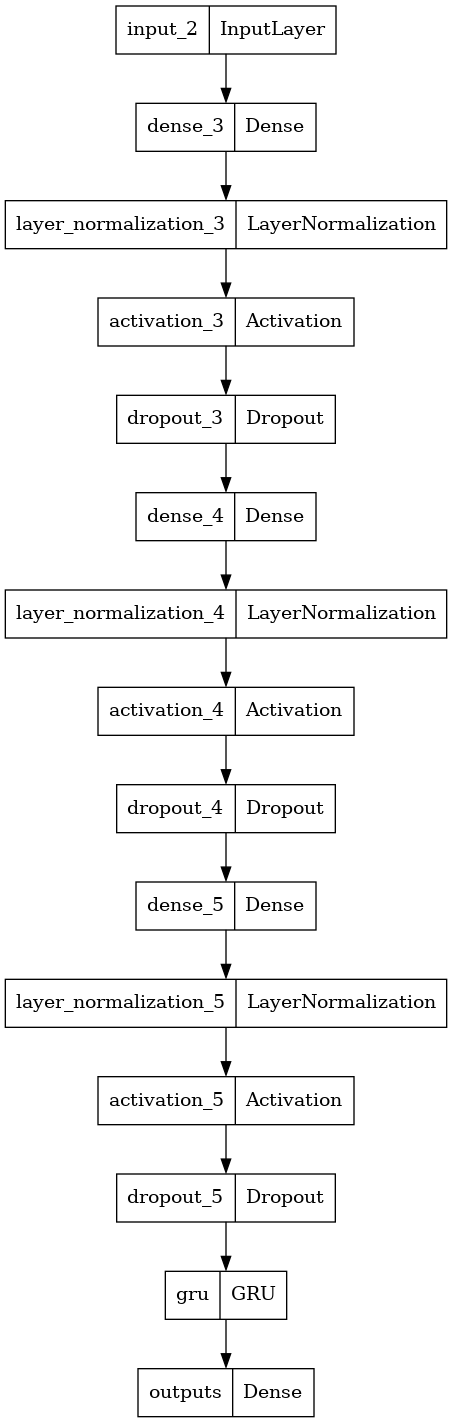

In [18]:
# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png')

In [19]:
# add a decreasing learning rate scheduler to help convergence
batch_size = 256
validation_percentage = 0.05
steps_per_epoch = int(94477*(1-validation_percentage)) // batch_size
boundaries = [steps_per_epoch * n for n in [23, 35, 45, 53, 60]]
print(boundaries)
values = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr_sched)
# optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

[8050, 12250, 15750, 18550, 21000]


In [21]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.2,
            patience = 5
        ),
    ]

In [32]:
# file_paths = df_train['path'].values#[:1000]
# y_sign = df_train['sign'].values#[:1000]
# X, y = get_data(file_paths, y_sign)

# X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percentage, random_state=123)
# X, X_test, y, y_test = train_test_split(X, y, test_size=validation_percentage, random_state=123)

# print(X.shape)
# print(y.shape)

In [22]:
history = model.fit(X, y, 
                epochs=500,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=2,
                callbacks=[get_callbacks()]
               )

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/500
334/334 - 24s - loss: 4.5619 - accuracy: 0.0836 - sparse_top_k_categorical_accuracy: 0.2346 - val_loss: 3.5554 - val_accuracy: 0.2039 - val_sparse_top_k_categorical_accuracy: 0.4867 - lr: 0.0010 - 24s/epoch - 73ms/step
Epoch 2/500
334/334 - 7s - loss: 3.1210 - accuracy: 0.2847 - sparse_top_k_categorical_accuracy: 0.5797 - val_loss: 3.1482 - val_accuracy: 0.2784 - val_sparse_top_k_categorical_accuracy: 0.5591 - lr: 0.0010 - 7s/epoch - 22ms/step
Epoch 3/500
334/334 - 7s - loss: 2.5827 - accuracy: 0.3931 - sparse_top_k_categorical_accuracy: 0.6840 - val_loss: 2.7933 - val_accuracy: 0.3389 - val_sparse_top_k_categorical_accuracy: 0.6397 - lr: 0.0010 - 7s/epoch - 21ms/step
Epoch 4/500
334/334 - 7s - loss: 2.2685 - accuracy: 0.4619 - sparse_top_k_categorical_accuracy: 0.7381 - val_loss: 2.4632 - val_accuracy: 0.4073 - val_sparse_top_k_categorical_accuracy: 0.6990 - lr: 0.0010 - 7s/epoch - 21ms/step
Epoch 5/500
334/334 - 7s - loss: 2.0723 - accuracy: 0.5028 - sparse_top_k_categori

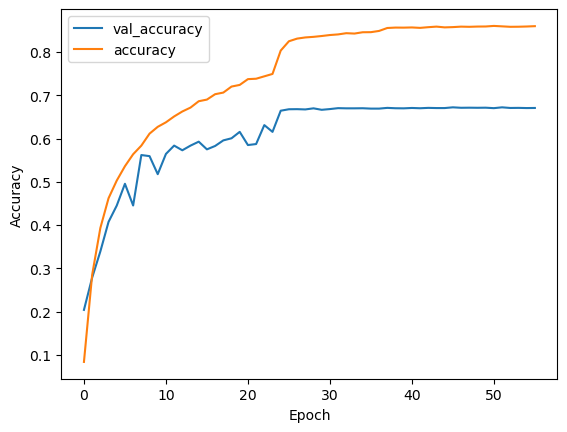

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(val_accuracy, label='val_accuracy')

plt.plot(accuracy, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

In [24]:
y_test_pred = model.predict(X_test)

141/141 [==============================] - 1s 5ms/step


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predictions = y_test_pred
labels = y_test

# Convert one-hot encoded predictions to integer labels
pred_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, F1-score, and accuracy for each class
precision = precision_score(labels, pred_labels, average=None)
recall = recall_score(labels, pred_labels, average=None)
f1 = f1_score(labels, pred_labels, average=None)
accuracy = accuracy_score(labels, pred_labels)

# Calculate macro-averaged metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-averaged Precision: {:.2f}%".format(macro_precision * 100))
print("Macro-averaged Recall: {:.2f}%".format(macro_recall * 100))
print("Macro-averaged F1-score: {:.2f}%".format(macro_f1 * 100))

Accuracy: 66.11%
Macro-averaged Precision: 66.17%
Macro-averaged Recall: 66.53%
Macro-averaged F1-score: 65.61%


## RNN

In [20]:
inputs = tf.keras.Input(shape=(None, input_length), ragged=True)
# choose the number of nodes per layer
embedding_units = [256, 128, 256] # tune this
transformer_units = []#, 512, 512]

# # dense encoder model
x = inputs
for n in embedding_units:
    x = dense_block(n)(x)
    
for t in transformer_units:
    x = transformer_block(t, x)

# classifier layer
if len(transformer_units) > 0:
    # Pooling
    x = tf.math.reduce_sum(x, axis=1)
    out = classifier_transformer()(x)
else:
    out = classifier_rnn(embedding_units[-1])(x)


model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 246)]       0         
                                                                 
 dense_3 (Dense)             (None, None, 256)         63232     
                                                                 
 layer_normalization_3 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, None, 256)         0         
                                                                 
 dropout_3 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_4 (Dense)             (None, None, 128)         32896     
                                                           

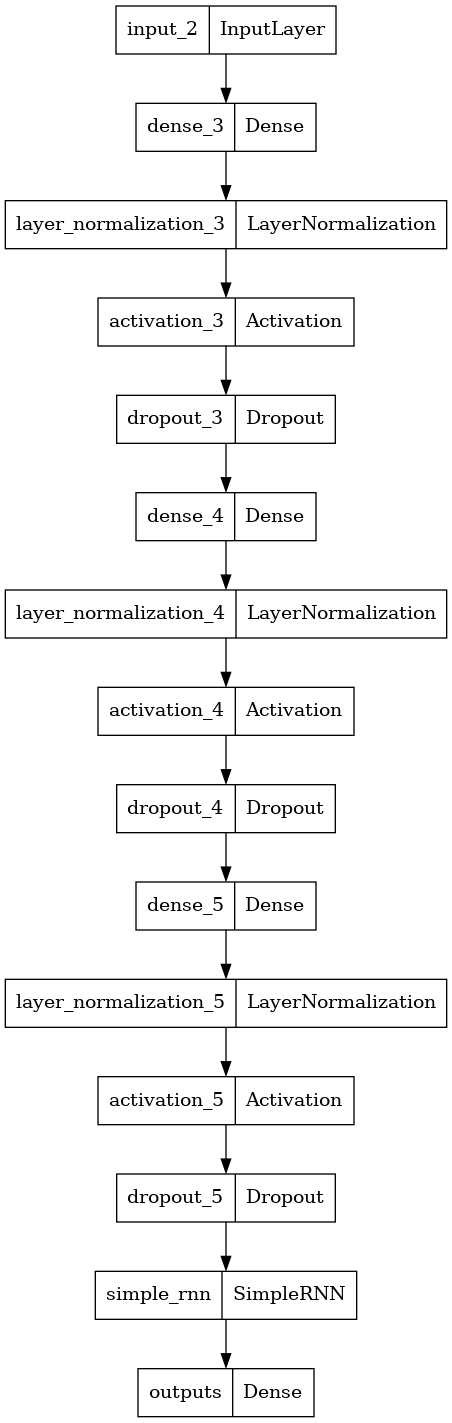

In [22]:
# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture_rnn.png')

In [23]:
# add a decreasing learning rate scheduler to help convergence
batch_size = 256
validation_percentage = 0.05
steps_per_epoch = int(94477*(1-validation_percentage)) // batch_size
boundaries = [steps_per_epoch * n for n in [23, 35, 45, 53, 60]]
print(boundaries)
values = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr_sched)
# optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

[8050, 12250, 15750, 18550, 21000]


In [27]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.2,
            patience = 10
        ),
    ]

In [25]:
file_paths = df_train['path'].values#[:1000]
y_sign = df_train['sign'].values#[:1000]
X, y = get_data(file_paths, y_sign)

X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percentage, random_state=123)
X, X_test, y, y_test = train_test_split(X, y, test_size=validation_percentage, random_state=123)

print(X.shape)
print(y.shape)

100%|██████████| 94477/94477 [35:52<00:00, 43.89it/s]  


(85265, 32, 246)
(85265,)


In [28]:
history = model.fit(X, y, 
                epochs=500,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=2,
                callbacks=[get_callbacks()]
               )

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/500
334/334 - 20s - loss: 4.6599 - accuracy: 0.0639 - sparse_top_k_categorical_accuracy: 0.2121 - val_loss: 4.7232 - val_accuracy: 0.0561 - val_sparse_top_k_categorical_accuracy: 0.1967 - lr: 0.0010 - 20s/epoch - 61ms/step
Epoch 2/500
334/334 - 19s - loss: 4.5936 - accuracy: 0.0720 - sparse_top_k_categorical_accuracy: 0.2280 - val_loss: 4.2735 - val_accuracy: 0.0970 - val_sparse_top_k_categorical_accuracy: 0.2983 - lr: 0.0010 - 19s/epoch - 57ms/step
Epoch 3/500
334/334 - 18s - loss: 4.6152 - accuracy: 0.0703 - sparse_top_k_categorical_accuracy: 0.2285 - val_loss: 5.4109 - val_accuracy: 0.0085 - val_sparse_top_k_categorical_accuracy: 0.0421 - lr: 0.0010 - 18s/epoch - 54ms/step
Epoch 4/500
334/334 - 19s - loss: 4.8178 - accuracy: 0.0445 - sparse_top_k_categorical_accuracy: 0.1613 - val_loss: 5.5486 - val_accuracy: 0.0222 - val_sparse_top_k_categorical_accuracy: 0.0906 - lr: 0.0010 - 19s/epoch - 56ms/step
Epoch 5/500
334/334 - 18s - loss: 4.5158 - accuracy: 0.0719 - sparse_top_k_c

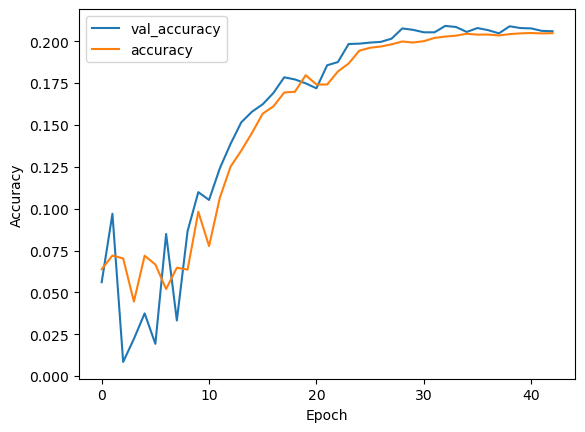

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(val_accuracy, label='val_accuracy')

plt.plot(accuracy, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

In [30]:
y_test_pred = model.predict(X_test)

141/141 [==============================] - 2s 7ms/step


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predictions = y_test_pred
labels = y_test

# Convert one-hot encoded predictions to integer labels
pred_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, F1-score, and accuracy for each class
precision = precision_score(labels, pred_labels, average=None)
recall = recall_score(labels, pred_labels, average=None)
f1 = f1_score(labels, pred_labels, average=None)
accuracy = accuracy_score(labels, pred_labels)

# Calculate macro-averaged metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-averaged Precision: {:.2f}%".format(macro_precision * 100))
print("Macro-averaged Recall: {:.2f}%".format(macro_recall * 100))
print("Macro-averaged F1-score: {:.2f}%".format(macro_f1 * 100))

Accuracy: 19.14%
Macro-averaged Precision: 18.98%
Macro-averaged Recall: 19.35%
Macro-averaged F1-score: 17.02%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Transformers

In [33]:
# a single dense block followed by a normalization block and relu activation
def dense_block(units):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    drop = layers.Dropout(0.05)
    return lambda x: drop(act(norm(fc(x))))

# transformer blocks
def transformer_block(key_dim, x):
    mha = MultiHeadAttention(key_dim, 8)(x)
    add1 = layers.add([mha, x])
    norm1 = layers.LayerNormalization()(add1)

    fc = layers.Dense(key_dim, activation="relu")(norm1)
    add2 = tf.math.add(fc, norm1)
    norm2 = layers.LayerNormalization()(add2)

    return norm2

# the final dense block for the classification
def classifier_lstm(units):
    lstm = layers.LSTM(units)
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(lstm(x))
    
def classifier_transformer(units):
    dense = layers.Dense(units, activation="relu")
    drop = layers.Dropout(0.1)
    
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(drop(dense(x)))

inputs = tf.keras.Input(shape=(None, input_length), ragged=True)
# choose the number of nodes per layer
embedding_units = [256] # tune this
transformer_units = [256]

# # dense encoder model
x = inputs
for n in embedding_units:
    x = dense_block(n)(x)
    
for t in transformer_units:
    x = transformer_block(t, x)

# classifier layer
if len(transformer_units) > 0:
    # Pooling
    x = tf.math.reduce_sum(x, axis=1)
    out = classifier_transformer(256)(x)
else:
    out = classifier_lstm(embedding_units[-1])(x)


model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 246)]  0           []                               
                                                                                                  
 dense_6 (Dense)                (None, None, 256)    63232       ['input_3[0][0]']                
                                                                                                  
 layer_normalization_6 (LayerNo  (None, None, 256)   512         ['dense_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, None, 256)    0           ['layer_normalization_6[0][

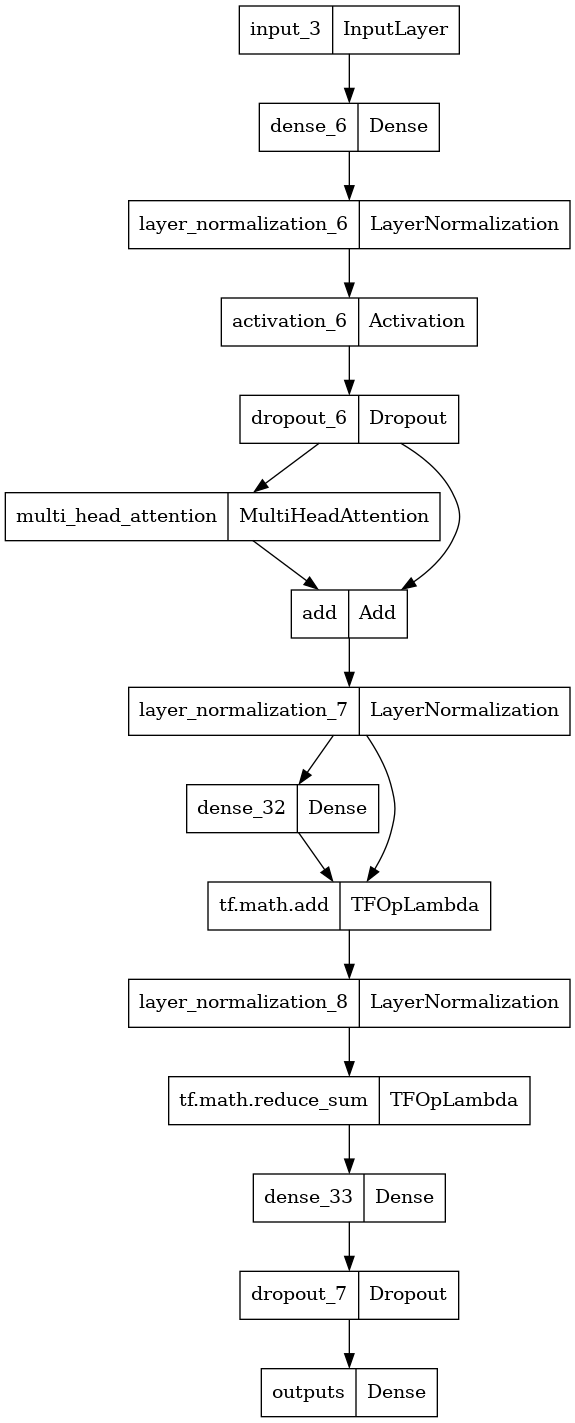

In [34]:
# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture_transformer.png')

In [45]:
# add a decreasing learning rate scheduler to help convergence
batch_size = 256
validation_percentage = 0.05
steps_per_epoch = int(94477*(1-validation_percentage)) // batch_size
boundaries = [steps_per_epoch * n for n in [23, 35, 45, 53, 60]]
print(boundaries)
values = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr = 0.00001)
# optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

[8050, 12250, 15750, 18550, 21000]


In [46]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.2,
            patience = 20
        ),
    ]

In [ ]:
# file_paths = df_train['path'].values[:1000]
# y_sign = df_train['sign'].values[:1000]
# X, y = get_data(file_paths, y_sign)

# X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percentage, random_state=123)
# X, X_test, y, y_test = train_test_split(X, y, test_size=validation_percentage, random_state=123)

# print(X.shape)
# print(y.shape)

history = model.fit(X, y, 
                epochs=500,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=2,
                callbacks=[get_callbacks()]
               )

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/500


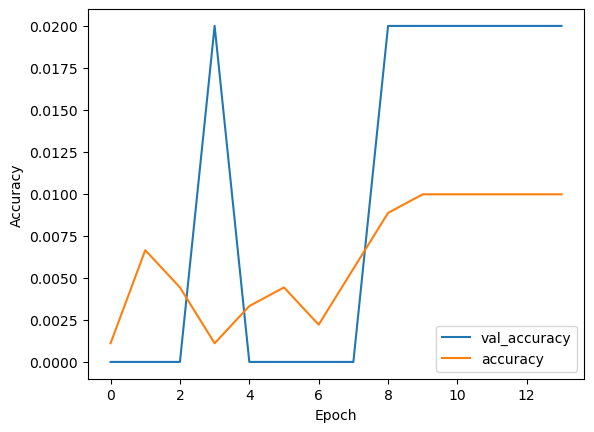

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(val_accuracy, label='val_accuracy')

plt.plot(accuracy, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

In [30]:
y_test_pred = model.predict(X_test)

141/141 [==============================] - 2s 7ms/step


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predictions = y_test_pred
labels = y_test

# Convert one-hot encoded predictions to integer labels
pred_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, F1-score, and accuracy for each class
precision = precision_score(labels, pred_labels, average=None)
recall = recall_score(labels, pred_labels, average=None)
f1 = f1_score(labels, pred_labels, average=None)
accuracy = accuracy_score(labels, pred_labels)

# Calculate macro-averaged metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-averaged Precision: {:.2f}%".format(macro_precision * 100))
print("Macro-averaged Recall: {:.2f}%".format(macro_recall * 100))
print("Macro-averaged F1-score: {:.2f}%".format(macro_f1 * 100))

Accuracy: 19.14%
Macro-averaged Precision: 18.98%
Macro-averaged Recall: 19.35%
Macro-averaged F1-score: 17.02%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

